#**Hybrid Forescasting: drNN and ES**
###**FINAL PROJECT GROUP 3**

1. Shabrina Nur Ihsani (5026221002)
2. Nailah Azzahra (5026221010)
3. Kayla Kirani Kusnadi (5026221111)

#**Import Library and Read Data**

In [ ]:
# Import Library Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Membaca Datasets Mentah
data = pd.read_csv('data.csv')
data

,Tanggal,Temperatur rata-rata (°C)
0,1/1/2019,26.0
1,1/2/2019,28.3
2,1/3/2019,28.3
3,1/4/2019,29.3
4,1/5/2019,28.9
...,...,...
1942,4/26/2024,30.2
1943,4/27/2024,29.5
1944,4/28/2024,30.2
1945,4/29/2024,31.3


#**Exploratory Data Analysis**

## Cleaning

In [ ]:
# Print Data
data.head()

,Tanggal,Temperatur rata-rata (°C)
0,1/1/2019,26.0
1,1/2/2019,28.3
2,1/3/2019,28.3
3,1/4/2019,29.3
4,1/5/2019,28.9


In [ ]:
# Cek Null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tanggal                    1947 non-null   object 
 1   Temperatur rata-rata (°C)  1947 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.5+ KB


## EDA

In [ ]:
# Pemisahan kolom

# Split Kolom Tanggal
data[['Month','Day','Year']] = data['Tanggal'].str.split('/', expand=True)

# Print data
data

,Tanggal,Temperatur rata-rata (°C),Month,Day,Year
0,1/1/2019,26.0,1,1,2019
1,1/2/2019,28.3,1,2,2019
2,1/3/2019,28.3,1,3,2019
3,1/4/2019,29.3,1,4,2019
4,1/5/2019,28.9,1,5,2019
...,...,...,...,...,...
1942,4/26/2024,30.2,4,26,2024
1943,4/27/2024,29.5,4,27,2024
1944,4/28/2024,30.2,4,28,2024
1945,4/29/2024,31.3,4,29,2024


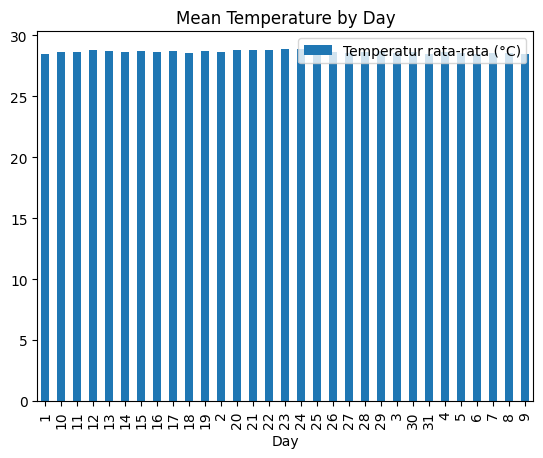

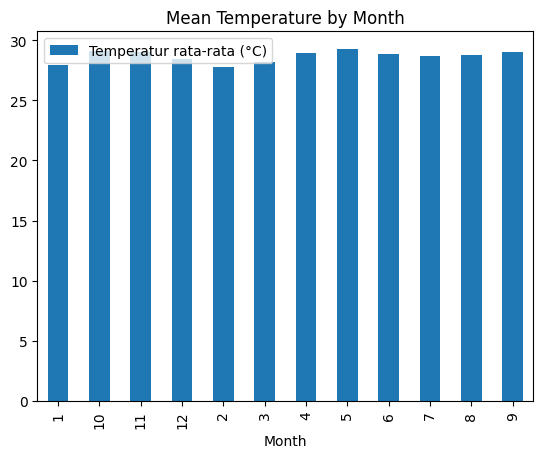

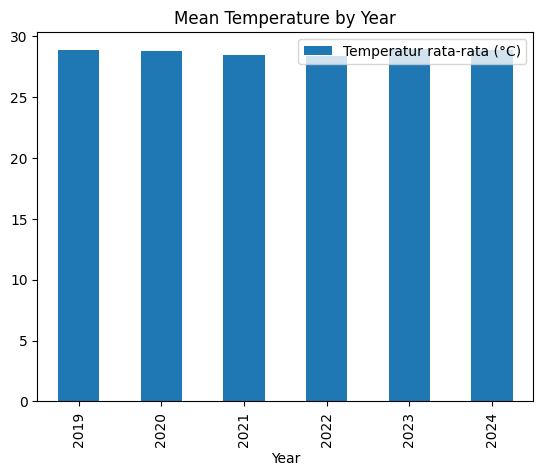

In [ ]:
# EDA
cat_cols = ['Day', 'Month', 'Year']

for col in cat_cols:
    data[['Temperatur rata-rata (°C)', col]].groupby(col).mean().plot.bar()
    plt.title(f'Mean Temperature by {col}')
    plt.show()

In [ ]:
cat_cols = ['Day', 'Month', 'Year']

for col in cat_cols:
    mean_temps = data[['Temperatur rata-rata (°C)', col]].groupby(col).mean()
    print(f'Rata-rata Temperature by {col}:')
    print(mean_temps)
    print('\n')

Rata-rata Temperature by Day:
     Temperatur rata-rata (°C)
Day                           
1                    28.442187
10                   28.628125
11                   28.645312
12                   28.760938
13                   28.717188
14                   28.614062
15                   28.710938
16                   28.662500
17                   28.678125
18                   28.535937
19                   28.704687
2                    28.587500
20                   28.820312
21                   28.756250
22                   28.787500
23                   28.862500
24                   28.875000
25                   28.523438
26                   28.643750
27                   28.562500
28                   28.617188
29                   28.685000
3                    28.521875
30                   28.622414
31                   28.483784
4                    28.623438
5                    28.557813
6                    28.421875
7                    28.545313
8        

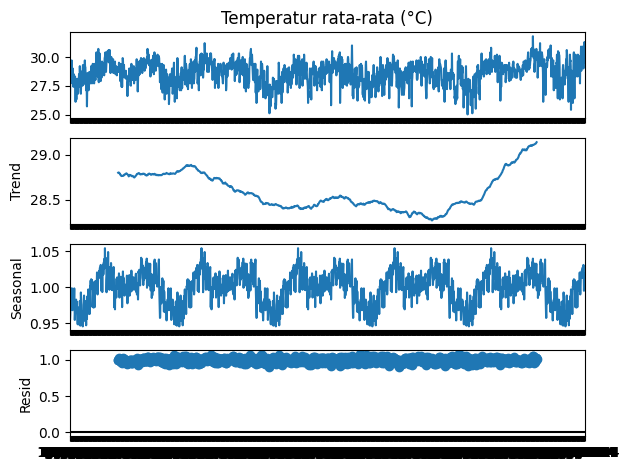

In [ ]:
# Mencari Pola Seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
ts = data.set_index('Tanggal')['Temperatur rata-rata (°C)'] + 0.01
result = seasonal_decompose(ts, model='multiplicative', period=365)
result.plot()
plt.show()

In [ ]:
# Drop kolom non angka
data.drop(columns = ['Tanggal', 'Day', 'Month', 'Year'], inplace=True)

In [ ]:
# Cek Null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperatur rata-rata (°C)  1947 non-null   float64
dtypes: float64(1)
memory usage: 15.3 KB


array([<Axes: >], dtype=object)

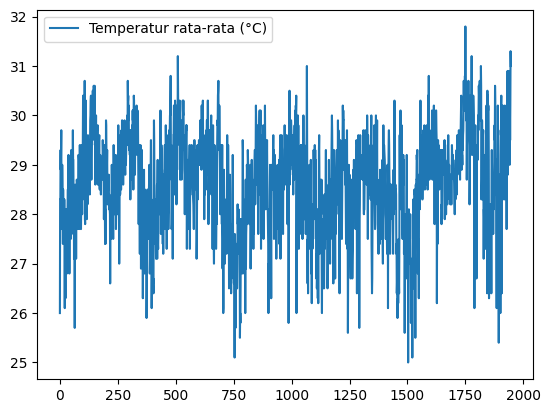

In [ ]:
# Plot
data.plot(subplots = True)

In [ ]:
# Describe
data.describe()

,Temperatur rata-rata (°C)
count,1947.000000
mean,28.636107
std,1.010950
min,25.000000
25%,28.000000
50%,28.700000
75%,29.300000
max,31.800000


## Pre-Processing

In [ ]:
# Import Library
from sklearn.preprocessing import MinMaxScaler #to normalize
from sklearn.model_selection import train_test_split #to train-test split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator #to create sliding window

In [ ]:
# Mengubah Kolom Index
data = pd.read_csv('data.csv', parse_dates = ['Tanggal'], index_col= 'Tanggal')
data.head()

,Temperatur rata-rata (°C)
Tanggal,
2019-01-01,26.0
2019-01-02,28.3
2019-01-03,28.3
2019-01-04,29.3
2019-01-05,28.9


In [ ]:
# Split the data into train and test sets
def train_test_split(data, train_ratio):
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# List of scenarios
scenarios = [0.8, 0.7, 0.6]

# **ES**

### Deseasonalized

In [ ]:
def deseasonalize_data(data, train_ratio, seasonal_periods=365):
    # Split the data
    train, test = train_test_split(data, train_ratio)

    # Decompose the training data
    result_train = seasonal_decompose(train, model='multiplicative', period=seasonal_periods)

    # Remove seasonality from training data
    train_desesonalized = train / result_train.seasonal

    # Remove seasonality from test data
    # Assume that the seasonal component for test data is the same as the last observed seasonal component from train data
    test_seasonal_component = result_train.seasonal[-seasonal_periods:].values
    test_seasonal_component = np.tile(test_seasonal_component, int(np.ceil(len(test) / seasonal_periods)))[:len(test)]
    test_seasonal_component = pd.Series(test_seasonal_component, index=test.index)
    test_desesonalized = test / test_seasonal_component

    return train, test, train_desesonalized, test_desesonalized, result_train, test_seasonal_component


In [ ]:
def plot_data(train, test, train_desesonalized, test_desesonalized, result, train_ratio):
    # Plot decomposed components
    result.plot()
    plt.suptitle(f'Decomposition of Training Data (Train Ratio = {train_ratio})', y=1.02)
    plt.show()

    # Combine train and test data for plotting
    combined_data = pd.concat([train, test])
    combined_desesonalized = pd.concat([train_desesonalized, test_desesonalized])

    # Plotting original and desesonalized combined data
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data.index, combined_data, label='Original Data')
    plt.plot(combined_data.index, combined_desesonalized, label='Desesonalized Data')
    plt.axvline(train.index[-1], color='gray', linestyle='--', label='Train-Test Split')
    plt.legend()
    plt.title(f'Original vs Desesonalized Data (Train Ratio = {train_ratio})')
    plt.show()


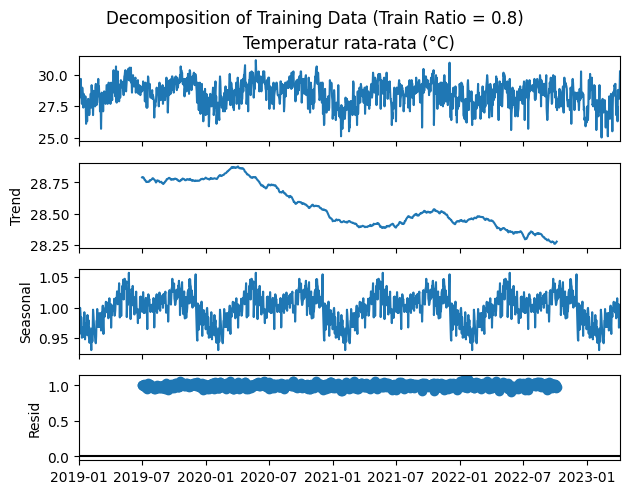

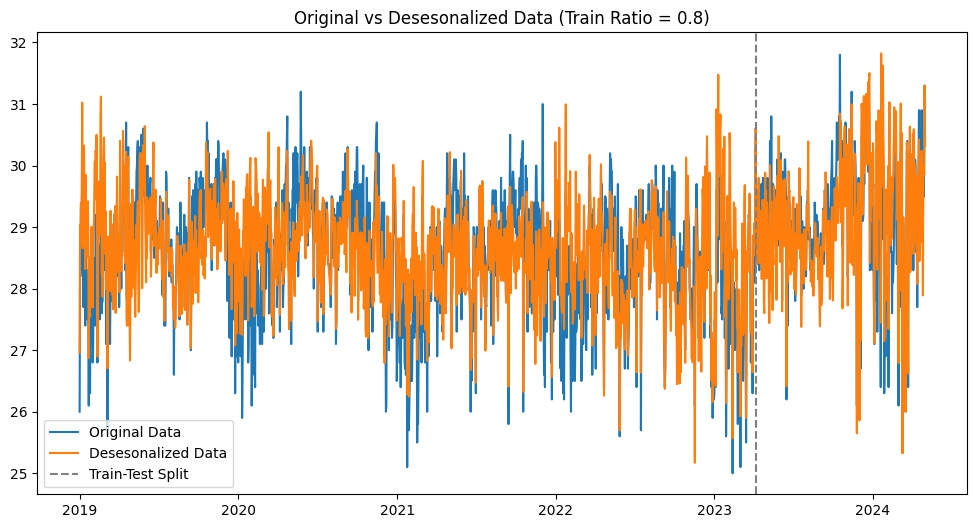

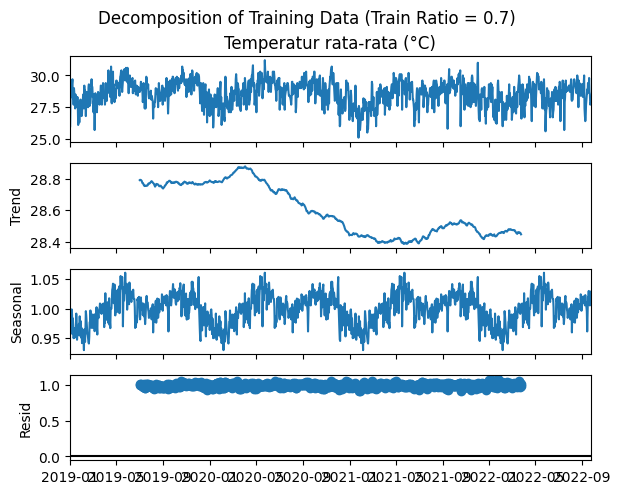

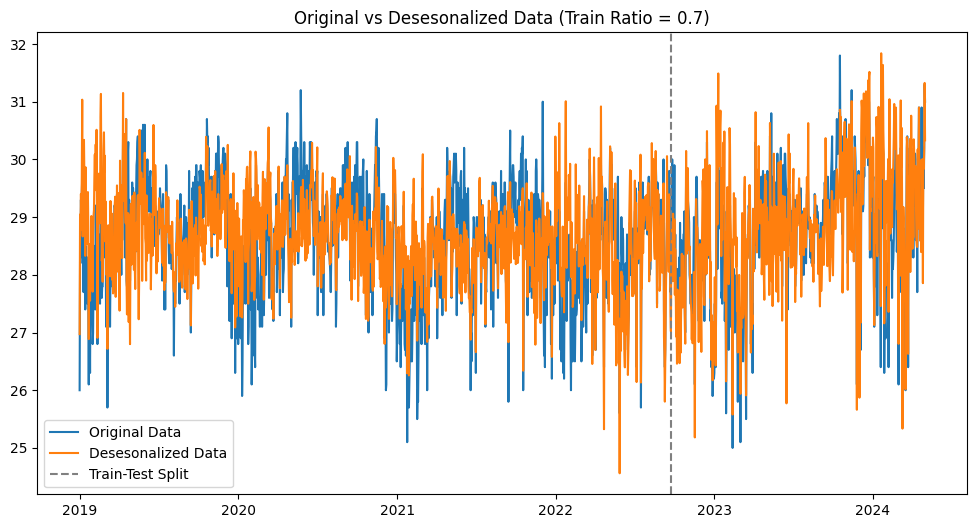

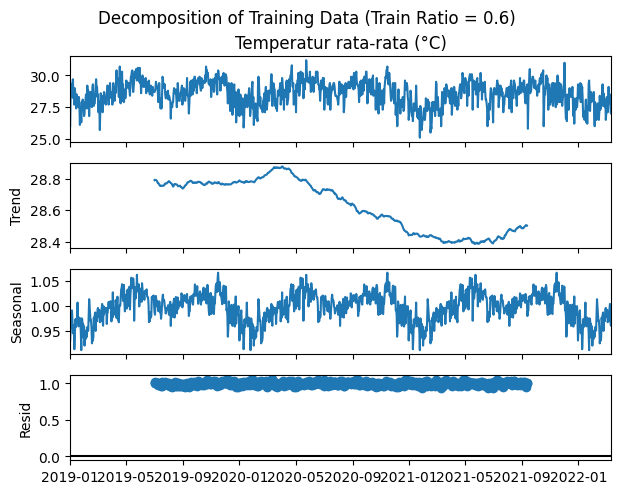

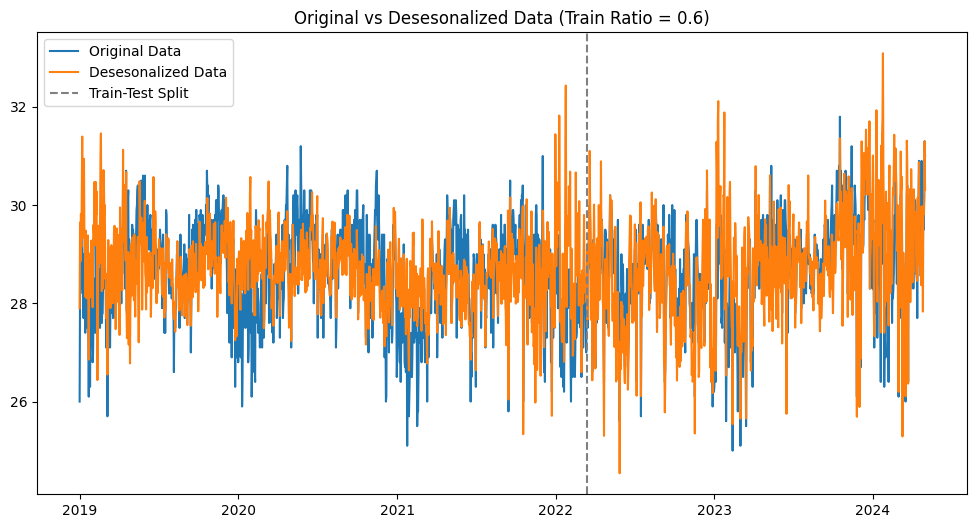

In [ ]:
# Result dictionary
results = {}

for scenario in scenarios:
    train, test, train_desesonalized, test_desesonalized, result_train, test_seasonal_component = deseasonalize_data(data['Temperatur rata-rata (°C)'], scenario)

    # Put the result into dictionary
    results[f'train_{scenario}'] = train
    results[f'test_{scenario}'] = test
    results[f'train_desesonalized_{scenario}'] = train_desesonalized
    results[f'test_desesonalized_{scenario}'] = test_desesonalized
    results[f'result_train_{scenario}'] = result_train
    results[f'test_seasonal_component_{scenario}'] = test_seasonal_component

    # Plotting
    plot_data(train, test, train_desesonalized, test_desesonalized, result_train, scenario)

# **dRNN**

### Pre-Processing

In [ ]:
train_desesonalized_1 = results['train_desesonalized_0.8']
train_desesonalized_2 = results['train_desesonalized_0.7']
train_desesonalized_3 = results['train_desesonalized_0.6']

test_desesonalized_1 = results['test_desesonalized_0.8']
test_desesonalized_2 = results['test_desesonalized_0.7']
test_desesonalized_3 = results['test_desesonalized_0.6']

# Normalisasi data desesionalisasi
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_1 = scaler.fit_transform(train_desesonalized_1.values.reshape(-1, 1))
test_scaled_1 = scaler.transform(test_desesonalized_1.values.reshape(-1, 1))

train_scaled_2 = scaler.fit_transform(train_desesonalized_2.values.reshape(-1, 1))
test_scaled_2 = scaler.transform(test_desesonalized_2.values.reshape(-1, 1))

train_scaled_3 = scaler.fit_transform(train_desesonalized_3.values.reshape(-1, 1))
test_scaled_3 = scaler.transform(test_desesonalized_3.values.reshape(-1, 1))

In [ ]:
# Menyiapkan dataset untuk pelatihan dRNN (LSTM)
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train_1, Y_train_1 = create_dataset(train_scaled_1, look_back)
X_test_1, Y_test_1 = create_dataset(test_scaled_1, look_back)

X_train_2, Y_train_2 = create_dataset(train_scaled_2, look_back)
X_test_2, Y_test_2 = create_dataset(test_scaled_2, look_back)

X_train_3, Y_train_3 = create_dataset(train_scaled_3, look_back)
X_test_3, Y_test_3 = create_dataset(test_scaled_3, look_back)

# Reshape input to be [samples, time steps, features]
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))

X_train_3 = np.reshape(X_train_3, (X_train_3.shape[0], X_train_3.shape[1], 1))
X_test_3 = np.reshape(X_test_3, (X_test_3.shape[0], X_test_3.shape[1], 1))

### Training

In [ ]:
# Building model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Training model
history_1 = model.fit(X_train_1, Y_train_1, epochs=50,
                      batch_size=1, validation_data=(X_test_1, Y_test_1),
                      verbose=2, shuffle=False)

history_2 = model.fit(X_train_2, Y_train_2, epochs=50,
                      batch_size=1, validation_data=(X_test_2, Y_test_2),
                      verbose=2, shuffle=False)

history_3 = model.fit(X_train_3, Y_train_3, epochs=50,
                      batch_size=1, validation_data=(X_test_3, Y_test_3),
                      verbose=2, shuffle=False)


Epoch 1/50
1527/1527 - 10s - loss: 0.0163 - val_loss: 0.0277 - 10s/epoch - 7ms/step
Epoch 2/50
1527/1527 - 6s - loss: 0.0125 - val_loss: 0.0309 - 6s/epoch - 4ms/step
Epoch 3/50
1527/1527 - 6s - loss: 0.0120 - val_loss: 0.0332 - 6s/epoch - 4ms/step
Epoch 4/50
1527/1527 - 6s - loss: 0.0118 - val_loss: 0.0356 - 6s/epoch - 4ms/step
Epoch 5/50
1527/1527 - 6s - loss: 0.0118 - val_loss: 0.0344 - 6s/epoch - 4ms/step
Epoch 6/50
1527/1527 - 7s - loss: 0.0117 - val_loss: 0.0320 - 7s/epoch - 4ms/step
Epoch 7/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0341 - 6s/epoch - 4ms/step
Epoch 8/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0359 - 6s/epoch - 4ms/step
Epoch 9/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0334 - 6s/epoch - 4ms/step
Epoch 10/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0367 - 6s/epoch - 4ms/step
Epoch 11/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0348 - 6s/epoch - 4ms/step
Epoch 12/50
1527/1527 - 6s - loss: 0.0117 - val_loss: 0.0342 - 6s/epoch - 4ms/step
Epoch 13/50

### Testing

In [ ]:
# Prediction
train_predict_1 = model.predict(X_train_1)
test_predict_1 = model.predict(X_test_1)

train_predict_2 = model.predict(X_train_2)
test_predict_2 = model.predict(X_test_2)

train_predict_3 = model.predict(X_train_3)
test_predict_3 = model.predict(X_test_3)

24/24 [==============================] - 0s 5ms/step


In [ ]:
# Invers Transformasi Data
train_predict_1 = scaler.inverse_transform(train_predict_1)
Y_train_1 = scaler.inverse_transform([Y_train_1])
test_predict_1 = scaler.inverse_transform(test_predict_1)
Y_test_1 = scaler.inverse_transform([Y_test_1])

train_predict_2 = scaler.inverse_transform(train_predict_2)
Y_train_2 = scaler.inverse_transform([Y_train_2])
test_predict_2 = scaler.inverse_transform(test_predict_2)
Y_test_2 = scaler.inverse_transform([Y_test_2])

train_predict_3 = scaler.inverse_transform(train_predict_3)
Y_train_3 = scaler.inverse_transform([Y_train_3])
test_predict_3 = scaler.inverse_transform(test_predict_3)
Y_test_3 = scaler.inverse_transform([Y_test_3])

### Evaluation

In [ ]:
# Import Library
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

# Scenario 1
tr_score_mse_1 = mean_squared_error(Y_train_1[0], train_predict_1[:,0])
ts_score_mse_1 = mean_squared_error(Y_test_1[0], test_predict_1[:,0])
tr_score_mae_1 = mean_absolute_error(Y_train_1[0], train_predict_1[:,0])
ts_score_mae_1 = mean_absolute_error(Y_test_1[0], test_predict_1[:,0])
tr_score_mape_1 = mean_absolute_percentage_error(Y_train_1[0], train_predict_1[:,0])
ts_score_mape_1 = mean_absolute_percentage_error(Y_test_1[0], test_predict_1[:,0])

# Scenario 2
tr_score_mse_2 = mean_squared_error(Y_train_2[0], train_predict_2[:,0])
ts_score_mse_2 = mean_squared_error(Y_test_2[0], test_predict_2[:,0])
tr_score_mae_2 = mean_absolute_error(Y_train_2[0], train_predict_2[:,0])
ts_score_mae_2 = mean_absolute_error(Y_test_2[0], test_predict_2[:,0])
tr_score_mape_2 = mean_absolute_percentage_error(Y_train_2[0], train_predict_2[:,0])
ts_score_mape_2 = mean_absolute_percentage_error(Y_test_2[0], test_predict_2[:,0])

# Scenario 3
tr_score_mse_3 = mean_squared_error(Y_train_3[0], train_predict_3[:,0])
ts_score_mse_3 = mean_squared_error(Y_test_3[0], test_predict_3[:,0])
tr_score_mae_3 = mean_absolute_error(Y_train_3[0], train_predict_3[:,0])
ts_score_mae_3 = mean_absolute_error(Y_test_3[0], test_predict_3[:,0])
tr_score_mape_3 = mean_absolute_percentage_error(Y_train_3[0], train_predict_3[:,0])
ts_score_mape_3 = mean_absolute_percentage_error(Y_test_3[0], test_predict_3[:,0])

In [ ]:
# Membuat DataFrame untuk hasil evaluasi Train
df_train = pd.DataFrame({
    'Metrik': ['MSE', 'MAE', 'MAPE'],
    'Scenario 1': [tr_score_mse_1, tr_score_mae_1, tr_score_mape_1],
    'Scenario 2': [tr_score_mse_2, tr_score_mae_2, tr_score_mape_2],
    'Scenario 3': [tr_score_mse_3, tr_score_mae_3, tr_score_mape_3]
}).round(2)

# Membuat DataFrame untuk hasil evaluasi Test
df_test = pd.DataFrame({
    'Metrik': ['MSE', 'MAE', 'MAPE'],
    'Scenario 1': [ts_score_mse_1, ts_score_mae_1, ts_score_mape_1],
    'Scenario 2': [ts_score_mse_2, ts_score_mae_2, ts_score_mape_2],
    'Scenario 3': [ts_score_mse_3, ts_score_mae_3, ts_score_mape_3]
}).round(2)

print("Evaluasi Train:")
print(df_train)
print("\nEvaluasi Test:")
print(df_test)

Evaluasi Train:
  Metrik  Scenario 1  Scenario 2  Scenario 3
0    MSE        1.01        1.74        0.45
1    MAE        0.81        1.15        0.51
2   MAPE        0.03        0.04        0.02

Evaluasi Test:
  Metrik  Scenario 1  Scenario 2  Scenario 3
0    MSE        2.46        2.83        1.39
1    MAE        1.30        1.42        0.91
2   MAPE        0.04        0.05        0.03


### Plotting

In [ ]:
result_1 = results['result_train_0.8']
result_2 = results['result_train_0.7']
result_3 = results['result_train_0.6']

test_seasonal_component_1 = results['test_seasonal_component_0.8']
test_seasonal_component_2 = results['test_seasonal_component_0.7']
test_seasonal_component_3 = results['test_seasonal_component_0.6']

# Mengembalikan komponen musiman dan tren ke prediksi
train_predict_rescaled_1 = train_predict_1.flatten() * result_1.seasonal[look_back:len(train_predict_1) + look_back]
test_predict_rescaled_1 = test_predict_1.flatten() * test_seasonal_component_1[look_back:len(test_predict_1) + look_back]

train_predict_rescaled_2 = train_predict_2.flatten() * result_2.seasonal[look_back:len(train_predict_2) + look_back]
test_predict_rescaled_2 = test_predict_2.flatten() * test_seasonal_component_2[look_back:len(test_predict_2) + look_back]

train_predict_rescaled_3 = train_predict_3.flatten() * result_3.seasonal[look_back:len(train_predict_3) + look_back]
test_predict_rescaled_3 = test_predict_3.flatten() * test_seasonal_component_3[look_back:len(test_predict_3) + look_back]


In [ ]:
train_1 = results['train_0.8']
train_2 = results['train_0.7']
train_3 = results['train_0.6']

test_1 = results['test_0.8']
test_2 = results['test_0.7']
test_3 = results['test_0.6']

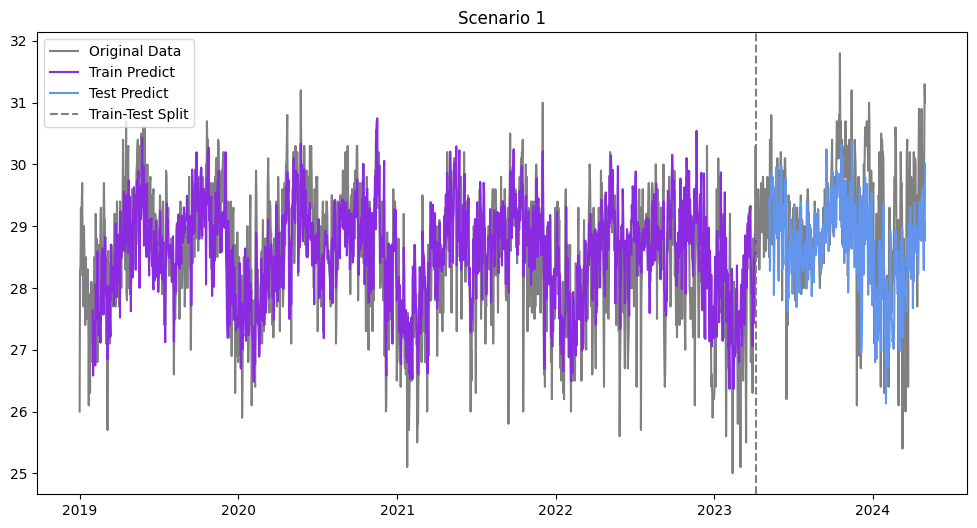

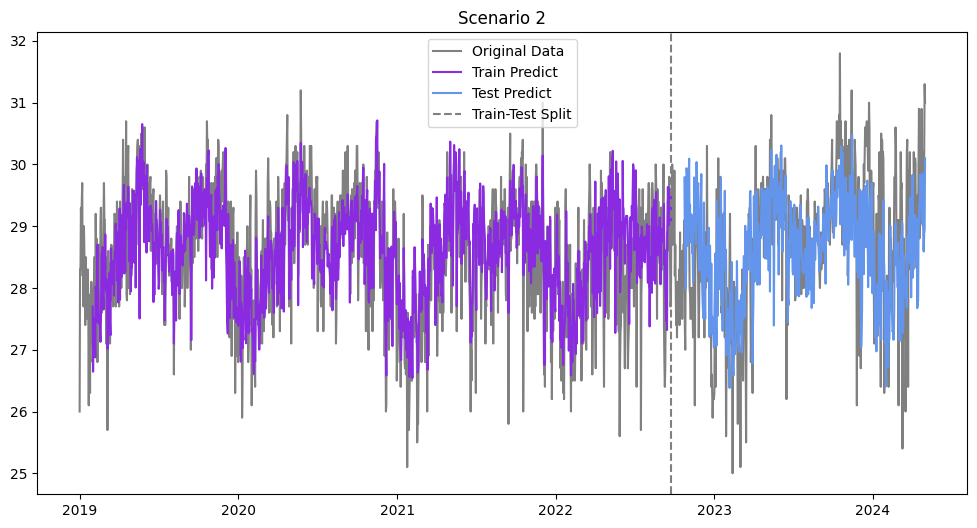

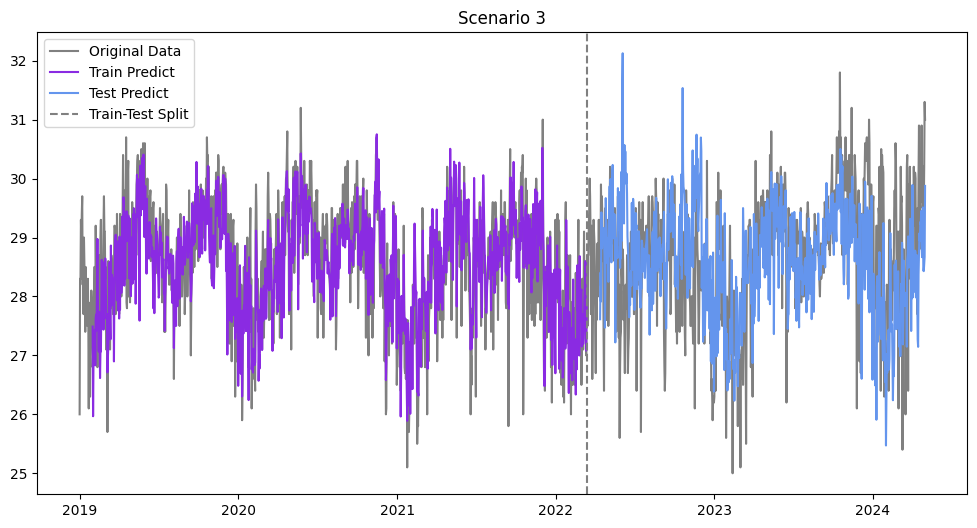

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_1.index[look_back:], train_predict_rescaled_1, color='blueviolet', label='Train Predict')
plt.plot(test_1.index[look_back:], test_predict_rescaled_1, color='cornflowerblue', label='Test Predict')
plt.axvline(train_1.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 1')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_2.index[look_back:], train_predict_rescaled_2, color='blueviolet', label='Train Predict')
plt.plot(test_2.index[look_back:], test_predict_rescaled_2, color='cornflowerblue',label='Test Predict')
plt.axvline(train_2.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 2')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_3.index[look_back:], train_predict_rescaled_3, color='blueviolet', label='Train Predict')
plt.plot(test_3.index[look_back:], test_predict_rescaled_3, color='cornflowerblue', label='Test Predict')
plt.axvline(train_3.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 3')
plt.show()

### Forecasting

In [ ]:
# Forecasting satu tahun ke depan (365 hari)
forecast_periods = 365
forecast_input_1 = test_scaled_1[-look_back:]
forecast_1 = []

forecast_input_2 = test_scaled_2[-look_back:]
forecast_2 = []

forecast_input_3 = test_scaled_3[-look_back:]
forecast_3 = []

In [ ]:
for _ in range(forecast_periods):
    forecast_input_1 = np.reshape(forecast_input_1, (1, look_back, 1))
    predicted_temp_1 = model.predict(forecast_input_1)
    forecast_1.append(predicted_temp_1[0, 0])
    forecast_input_1 = np.append(forecast_input_1[0, 1:], predicted_temp_1, axis=0)

for _ in range(forecast_periods):
    forecast_input_2 = np.reshape(forecast_input_2, (1, look_back, 1))
    predicted_temp_2 = model.predict(forecast_input_2)
    forecast_2.append(predicted_temp_2[0, 0])
    forecast_input_2 = np.append(forecast_input_2[0, 1:], predicted_temp_2, axis=0)

for _ in range(forecast_periods):
    forecast_input_3 = np.reshape(forecast_input_3, (1, look_back, 1))
    predicted_temp_3 = model.predict(forecast_input_3)
    forecast_3.append(predicted_temp_3[0, 0])
    forecast_input_3 = np.append(forecast_input_3[0, 1:], predicted_temp_3, axis=0)


1/1 [==============================] - 0s 19ms/step


In [ ]:
# Invers Transformasi Data dan mengembalikan komponen musiman
forecast_1 = np.array(forecast_1).reshape(-1, 1)
forecast_1 = scaler.inverse_transform(forecast_1).flatten()

forecast_2 = np.array(forecast_2).reshape(-1, 1)
forecast_2 = scaler.inverse_transform(forecast_2).flatten()

forecast_3 = np.array(forecast_3).reshape(-1, 1)
forecast_3 = scaler.inverse_transform(forecast_3).flatten()

In [ ]:
seasonal_periods = 365

# Mengalikan komponen musiman yang diproyeksikan
future_seasonal_component_1 = np.tile(result_1.seasonal[-seasonal_periods:],
                                      int(np.ceil(forecast_periods / seasonal_periods)))[:forecast_periods]
forecast_rescaled_1 = forecast_1 * future_seasonal_component_1

future_seasonal_component_2 = np.tile(result_2.seasonal[-seasonal_periods:],
                                      int(np.ceil(forecast_periods / seasonal_periods)))[:forecast_periods]
forecast_rescaled_2 = forecast_2 * future_seasonal_component_2

future_seasonal_component_3 = np.tile(result_3.seasonal[-seasonal_periods:],
                                      int(np.ceil(forecast_periods / seasonal_periods)))[:forecast_periods]
forecast_rescaled_3 = forecast_3 * future_seasonal_component_3

In [ ]:
# Membuat DataFrame untuk tanggal prediksi
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date,
                             periods=forecast_periods + 1,
                             inclusive='right')


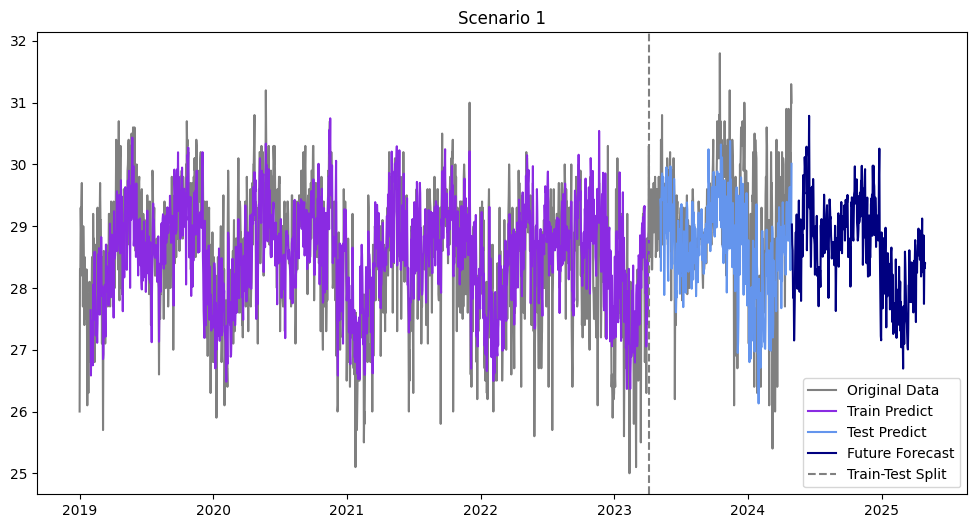

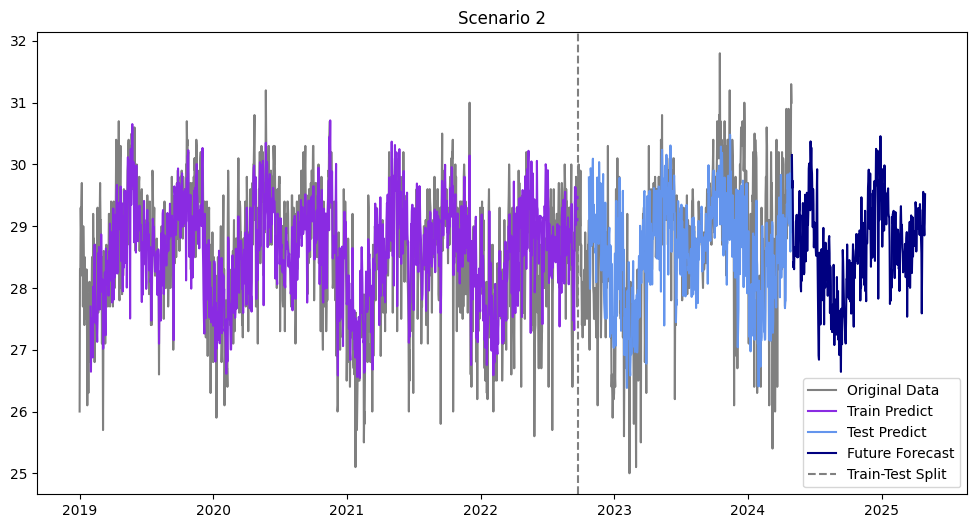

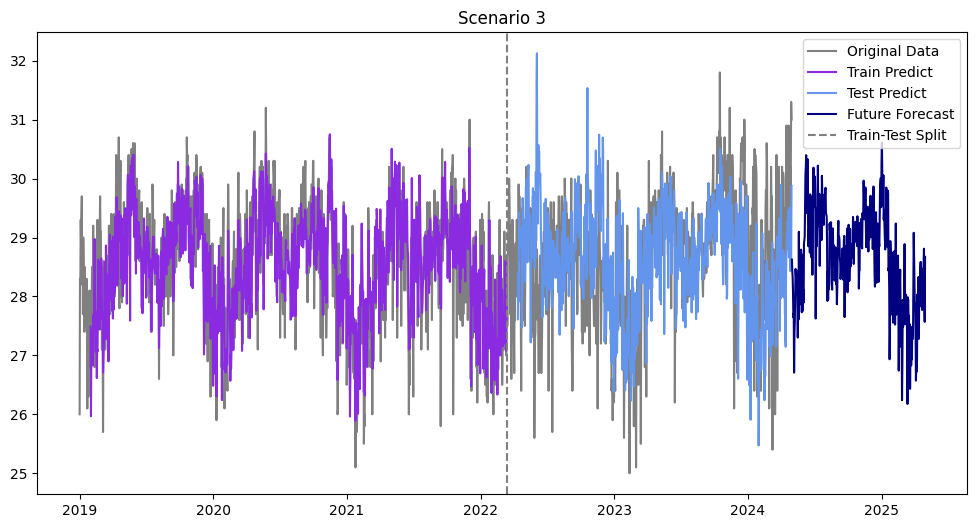

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_1.index[look_back:], train_predict_rescaled_1, color='BlueViolet', label='Train Predict')
plt.plot(test_1.index[look_back:], test_predict_rescaled_1, color='CornFlowerBlue', label='Test Predict')
plt.plot(future_dates, forecast_rescaled_1, color='Navy', label='Future Forecast')
plt.axvline(train_1.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 1')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_2.index[look_back:], train_predict_rescaled_2, color='BlueViolet', label='Train Predict')
plt.plot(test_2.index[look_back:], test_predict_rescaled_2, color='CornFlowerBlue', label='Test Predict')
plt.plot(future_dates, forecast_rescaled_2, color='Navy', label='Future Forecast')
plt.axvline(train_2.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 2')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Temperatur rata-rata (°C)'], color='grey', label='Original Data')
plt.plot(train_3.index[look_back:], train_predict_rescaled_3, color='BlueViolet', label='Train Predict')
plt.plot(test_3.index[look_back:], test_predict_rescaled_3, color='CornFlowerBlue', label='Test Predict')
plt.plot(future_dates, forecast_rescaled_3, color='Navy', label='Future Forecast')
plt.axvline(train_3.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.legend()
plt.title('Scenario 3')
plt.show()